In [1]:
import pandas as pd
import pyarrow.parquet as pq

# Importar el parquet desde la carpeta Insumos
df = pd.read_parquet('../Insumos/df_general.parquet')

construir manualmente el calendario de dispersión como variables exógenas tipo “holiday sin letras, sin separar por programas:

In [2]:
#mine
import pandas as pd

# Calendarios oficiales de dispersión
calendarios_oficiales = {
    '2024-07': pd.date_range('2024-07-01', '2024-07-22', freq='D'),
    '2024-09': pd.date_range('2024-09-02', '2024-09-20', freq='D'),
    '2024-11': pd.date_range('2024-11-04', '2024-11-28', freq='D'),
    '2025-01': pd.date_range('2025-01-02', '2025-01-22', freq='D'),
    '2025-03': pd.date_range('2025-03-03', '2025-03-27', freq='D'),
    '2025-09': pd.date_range('2025-09-02', '2025-09-21', freq='D'),
    '2025-11': pd.date_range('2025-11-04', '2025-11-28', freq='D'),
    '2026-01': pd.date_range('2026-01-05', '2026-01-28', freq='D')
}

# Construcción simple
holidays_simple = []

for periodo, fechas in calendarios_oficiales.items():
    for fecha in fechas:
        holidays_simple.append({
            'ds': fecha,
            'holiday': 'dispersion',
            'lower_window': 0, # El efecto empieza exactamente ese día
            'upper_window': 3#(:1)  # Cuántos días después del evento se mantiene el efecto
        })#podría convenir usar solo un día como efecto, a lo sumo 2.

holidays_df_simple = pd.DataFrame(holidays_simple)

print("HOLIDAYS SIMPLES (solo dispersión):")
print(f"Total filas: {len(holidays_df_simple)}")
print(f"Eventos únicos: {holidays_df_simple['holiday'].nunique()}")
# el total de filas son los días de dispersión calculados
# PARA EVALUAR SOLO PRESENCIA DEL PERÍODO COMPLETO:
# lower_window=0
# upper_window=0

HOLIDAYS SIMPLES (solo dispersión):
Total filas: 181
Eventos únicos: 1


Cuando se usan estas fechas (holidays) en Prophet o NeuralProphet:

El modelo NO va a estimar 181 efectos distintos.

Va a estimar solo un coeficiente:

$β_{dispersion}$

Es decir:
Cada vez que el día esté en ese calendario, se suma el mismo efecto. Se recibe el mismo tipo de impacto estructural.

Si se incluye la estimación por letra se deben calcular muchos coeficientes. Sin ellas sólo uno.

In [3]:
holidays_df_simple


,ds,holiday,lower_window,upper_window
0,2024-07-01,dispersion,0,3
1,2024-07-02,dispersion,0,3
2,2024-07-03,dispersion,0,3
3,2024-07-04,dispersion,0,3
4,2024-07-05,dispersion,0,3
...,...,...,...,...
176,2026-01-24,dispersion,0,3
177,2026-01-25,dispersion,0,3
178,2026-01-26,dispersion,0,3
179,2026-01-27,dispersion,0,3


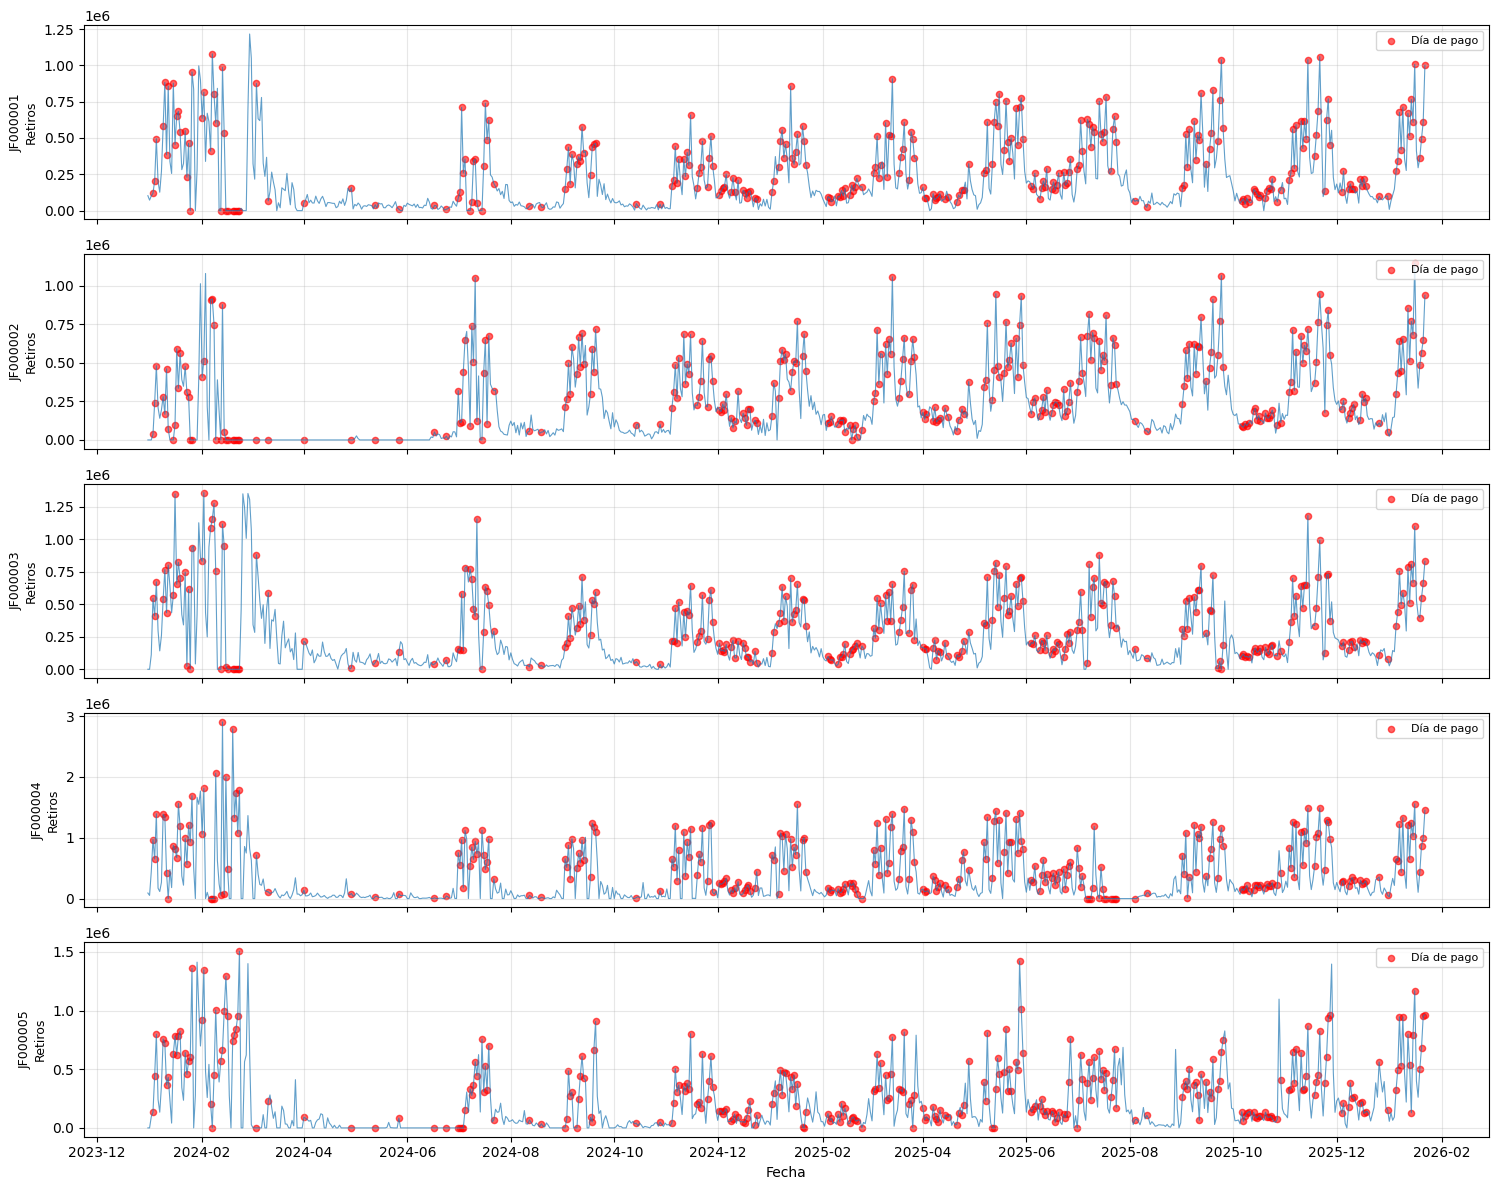


Estadísticas comparativas de cajeros muestra:

JF000001:
  Total retirado: $162,068,750
  % en días de pago: 65.5%
  Retiro promedio día pago: $347,133
  Retiro promedio día NO pago: $124,656

JF000002:
  Total retirado: $169,120,900
  % en días de pago: 66.2%
  Retiro promedio día pago: $366,061
  Retiro promedio día NO pago: $127,469

JF000003:
  Total retirado: $189,193,800
  % en días de pago: 61.9%
  Retiro promedio día pago: $382,491
  Retiro promedio día NO pago: $161,053

JF000004:
  Total retirado: $249,009,900
  % en días de pago: 76.5%
  Retiro promedio día pago: $622,155
  Retiro promedio día NO pago: $130,871

JF000005:
  Total retirado: $161,476,800
  % en días de pago: 67.4%
  Retiro promedio día pago: $355,820
  Retiro promedio día NO pago: $117,401


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Seleccionar varios cajeros para comparar patrones
cajeros_muestra = ['JF000001', 'JF000002', 'JF000003', 'JF000004', 'JF000005']

fig, axes = plt.subplots(len(cajeros_muestra), 1, figsize=(15, 12), sharex=True)

for i, cajero in enumerate(cajeros_muestra):
    df_cajero_plot = df[df['cajero'] == cajero].sort_values('fecha')
    
    ax = axes[i]
    ax.plot(df_cajero_plot['fecha'], df_cajero_plot['retiro'], linewidth=0.8, alpha=0.7)
    
    # Marcar días de pago con puntos rojos
    dias_pago_cajero = df_cajero_plot[df_cajero_plot['diapago'] == 1]
    ax.scatter(dias_pago_cajero['fecha'], dias_pago_cajero['retiro'], 
               color='red', s=20, alpha=0.6, label='Día de pago')
    
    ax.set_ylabel(f'{cajero}\nRetiros', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    
    # Formato de eje x
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

axes[-1].set_xlabel('Fecha', fontsize=10)
plt.tight_layout()
plt.show()

# Estadísticas comparativas de estos cajeros
print("\nEstadísticas comparativas de cajeros muestra:")
for cajero in cajeros_muestra:
    df_cajero_stats = df[df['cajero'] == cajero]
    total_retiros = df_cajero_stats['retiro'].sum()
    retiros_dias_pago = df_cajero_stats[df_cajero_stats['diapago'] == 1]['retiro'].sum()
    pct_en_dias_pago = (retiros_dias_pago / total_retiros * 100) if total_retiros > 0 else 0
    
    print(f"\n{cajero}:")
    print(f"  Total retirado: ${total_retiros:,.0f}")
    print(f"  % en días de pago: {pct_en_dias_pago:.1f}%")
    print(f"  Retiro promedio día pago: ${df_cajero_stats[df_cajero_stats['diapago']==1]['retiro'].mean():,.0f}")
    print(f"  Retiro promedio día NO pago: ${df_cajero_stats[df_cajero_stats['diapago']==0]['retiro'].mean():,.0f}")

Datos desde 2024-07-01:
  Observaciones: 571
  Rango: 2024-07-01 00:00:00 a 2026-01-22 00:00:00
  Retiro promedio: $221,272
  Retiro mediano: $146,500


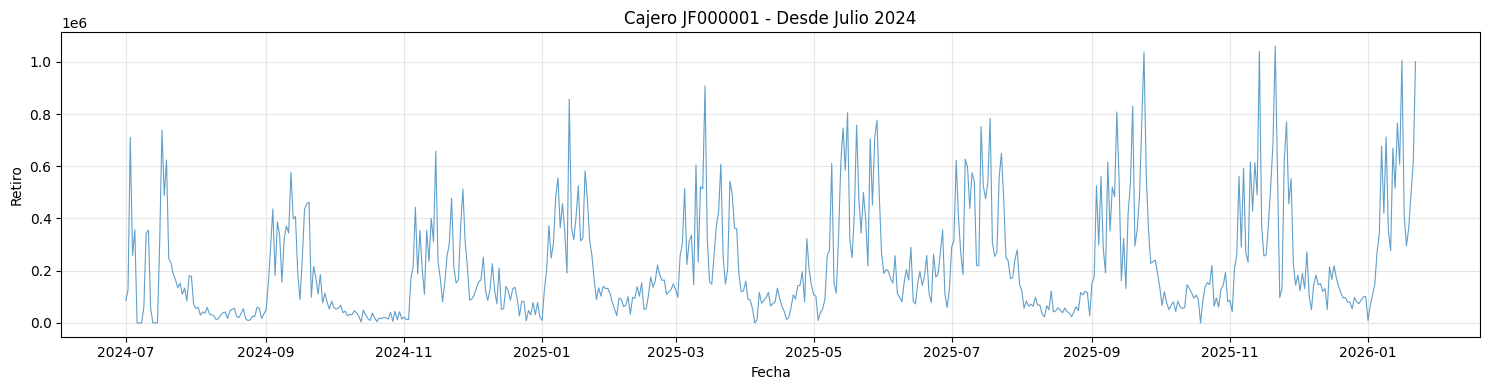

In [5]:
# Entrenar desde julio 2024 con todo el histórico de crecimiento ##### aquí reiniciaba en la segunda etapa
fecha_inicio = '2024-07-01'

df_modelo = df[df['fecha'] >= fecha_inicio].copy()

cajero_test = 'JF000001'
df_cajero = df_modelo[df_modelo['cajero'] == cajero_test][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Datos desde {fecha_inicio}:")
print(f"  Observaciones: {len(df_cajero)}")
print(f"  Rango: {df_cajero['ds'].min()} a {df_cajero['ds'].max()}")
print(f"  Retiro promedio: ${df_cajero['y'].mean():,.0f}")
print(f"  Retiro mediano: ${df_cajero['y'].median():,.0f}")

# Verificar tendencia visual
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 4))
plt.plot(df_cajero['ds'], df_cajero['y'], alpha=0.7, linewidth=0.8)
plt.title(f'Cajero {cajero_test} - Desde Julio 2024')
plt.xlabel('Fecha')
plt.ylabel('Retiro')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


Cajero JF000001: 571 observaciones
Percentil 90 días de dispersión: $624,300
Resumen eventos:
dispersion_normal     157
dispersion_extrema     18
dtype: int64
Entrenando modelo con dispersión normal vs extrema...


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True)

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.



Epoch 1:   0%|          | 1/250 [00:00<00:00, 300.39it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:54<?, ?it/s, v_num=94, train_loss=5.39e+10, reg_loss=0.000, MAE=1.53e+5, RMSE=2.09e+5, Loss=5.65e+10, RegLoss=0.000]

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\li

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\Temporal\Desktop\Prophet_banco_bienestar\venv\li

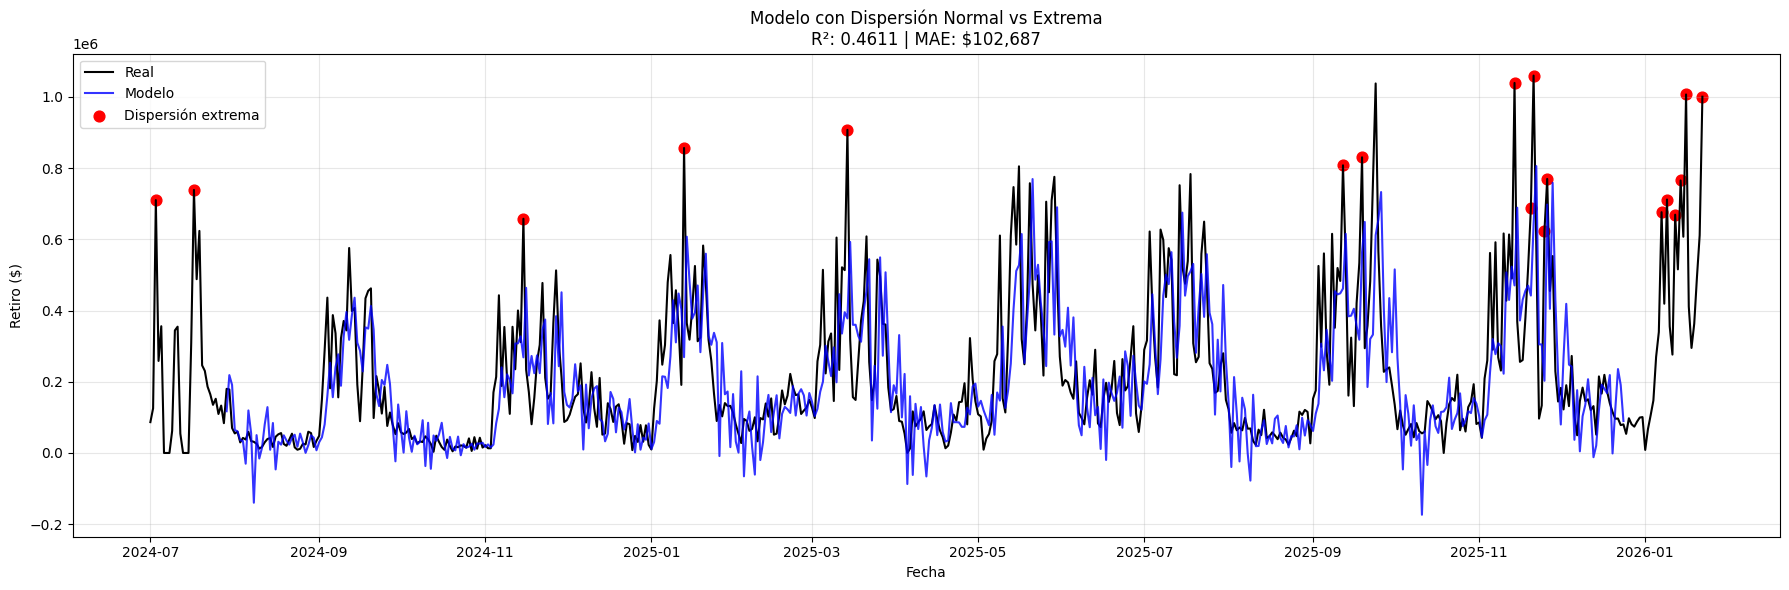


MODELO CON DISPERSIÓN SEGMENTADA
R²   : 0.4611
MAE  : $102,687
RMSE : $145,538
Días dispersión normal : 157
Días dispersión extrema: 18


In [7]:
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

# ============================================================
# PREPARAR DATOS
# ============================================================

fecha_inicio = '2024-07-01'
cajero_test = 'JF000001'

df_cajero = df[
    (df['fecha'] >= fecha_inicio) & 
    (df['cajero'] == cajero_test)
][['fecha', 'retiro']].copy()

df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

print(f"Cajero {cajero_test}: {len(df_cajero)} observaciones")

# ============================================================
# IDENTIFICAR DÍAS DE DISPERSIÓN
# ============================================================

# Se asume que ya tienes un dataframe llamado:
# dias_dispersion_df con columna 'ds'

df_cajero['es_dispersion'] = df_cajero['ds'].isin(
    holidays_df_simple['ds']
).astype(int)

# Percentil 90 histórico SOLO en días de dispersión
p90_dispersion = df_cajero.loc[
    df_cajero['es_dispersion'] == 1, 'y'
].quantile(0.90)

print(f"Percentil 90 días de dispersión: ${p90_dispersion:,.0f}")

# Crear variable de dispersión extrema
df_cajero['dispersion_extrema'] = np.where(
    (df_cajero['es_dispersion'] == 1) &
    (df_cajero['y'] >= p90_dispersion),
    1, 0
)

# Dispersión normal (las que no son extremas)
df_cajero['dispersion_normal'] = np.where(
    (df_cajero['es_dispersion'] == 1) &
    (df_cajero['y'] < p90_dispersion),
    1, 0
)

print("Resumen eventos:")
print(df_cajero[['dispersion_normal', 'dispersion_extrema']].sum())

# ============================================================
# MODELO NEURALPROPHET
# ============================================================

modelo = NeuralProphet(
    growth='linear',
    n_changepoints=20,
    changepoints_range=0.95,
    trend_reg=0.05,
    n_forecasts=30,
    n_lags=28,
    yearly_seasonality=15,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs=250,
    batch_size=32,
    learning_rate=0.001,
    loss_func='MSE',  # IMPORTANTE para capturar picos grandes
    normalize='off',
    quantiles=[0.05, 0.95]
)

# Agregar eventos
modelo = modelo.add_events("dispersion_normal")
modelo = modelo.add_events("dispersion_extrema")

print("Entrenando modelo con dispersión normal vs extrema...")
df_modelo = df_cajero[['ds', 'y', 'dispersion_normal', 'dispersion_extrema']].copy()

metrics = modelo.fit(df_modelo, freq='D')

forecast_hist = modelo.predict(df_modelo)

# ============================================================
# MÉTRICAS
# ============================================================

merged = df_cajero.merge(
    forecast_hist[['ds', 'yhat1']], 
    on='ds'
).dropna(subset=['yhat1'])

mae = (merged['yhat1'] - merged['y']).abs().mean()
rmse = ((merged['yhat1'] - merged['y'])**2).mean()**0.5
r2 = r2_score(merged['y'], merged['yhat1'])

# ============================================================
# GRÁFICO
# ============================================================

plt.figure(figsize=(18,6))

plt.plot(df_cajero['ds'], df_cajero['y'], 
         label='Real', color='black', linewidth=1.5)

plt.plot(merged['ds'], merged['yhat1'], 
         label='Modelo', color='blue', alpha=0.8)

# Marcar dispersión extrema en rojo
extremos = df_cajero[df_cajero['dispersion_extrema'] == 1]

plt.scatter(extremos['ds'], extremos['y'],
            color='red', s=60, label='Dispersión extrema')

plt.title(f'Modelo con Dispersión Normal vs Extrema\nR²: {r2:.4f} | MAE: ${mae:,.0f}', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Retiro ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# RESUMEN FINAL
# ============================================================

print("\n" + "="*60)
print("MODELO CON DISPERSIÓN SEGMENTADA")
print(f"R²   : {r2:.4f}")
print(f"MAE  : ${mae:,.0f}")
print(f"RMSE : ${rmse:,.0f}")
print(f"Días dispersión normal : {df_cajero['dispersion_normal'].sum()}")
print(f"Días dispersión extrema: {df_cajero['dispersion_extrema'].sum()}")


In [ ]:
from neuralprophet import NeuralProphet
print("OK")


ModuleNotFoundError: No module named 'pkg_resources'

In [ ]:
from neuralprophet import NeuralProphet
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from itertools import product

# Preparar datos
fecha_inicio = '2024-07-01'
cajero_test = 'JF000001'
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)

# Definir espacio de búsqueda
param_grid = {
    'n_changepoints': [5, 10, 15, 20, 25],
    'changepoints_range': [0.8, 0.85, 0.9, 0.95],
    'trend_reg': [0.01, 0.05, 0.1, 0.5, 1.0],
    'n_lags': [7, 14, 21, 28],
    'yearly_seasonality': [6, 8, 10, 12, 15],
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005]
}

# Configurar tipo de holidays a probar
holidays_type = 'granular'  # Cambiar a 'agregado' si quieres probar ese

# Preparar dataframe con eventos
df_cajero_eventos = df_cajero.copy()
holidays_usar = holidays_df_granular if holidays_type == 'granular' else holidays_df_agregado

for holiday_name in holidays_usar['holiday'].unique():
    fechas_holiday = holidays_usar[holidays_usar['holiday'] == holiday_name]['ds'].values
    df_cajero_eventos[holiday_name] = df_cajero_eventos['ds'].isin(fechas_holiday).astype(int)

print(f"Espacio de búsqueda: {np.prod([len(v) for v in param_grid.values()]):,} combinaciones posibles")
print(f"Holidays: {holidays_type} ({holidays_usar['holiday'].nunique()} eventos)")

# Random Search (probar N combinaciones aleatorias)
n_iterations = 50  # Ajusta según tiempo disponible
print(f"\nProbando {n_iterations} combinaciones aleatorias...")

resultados = []

for i in range(n_iterations):
    # Generar combinación aleatoria
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    
    print(f"\n[{i+1}/{n_iterations}] Probando: {params}")
    
    try:
        modelo = NeuralProphet(
            growth='linear',
            n_changepoints=params['n_changepoints'],
            changepoints_range=params['changepoints_range'],
            trend_reg=params['trend_reg'],
            n_forecasts=30,
            n_lags=params['n_lags'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=False,
            daily_seasonality=False,
            epochs=100,  # Reducido para velocidad
            batch_size=32,
            learning_rate=params['learning_rate'],
            loss_func='Huber',
            normalize='off',
            quantiles=[0.05, 0.95]
        )
        
        for holiday_name in holidays_usar['holiday'].unique():
            modelo = modelo.add_events(holiday_name)
        
        metrics = modelo.fit(df_cajero_eventos, freq='D') #df[-:80]
        forecast = modelo.predict(df_cajero_eventos)#df[-80:]
        
        merged = df_cajero.merge(forecast[['ds', 'yhat1']], on='ds').dropna(subset=['yhat1'])
        
        if len(merged) > 0:
            r2 = r2_score(merged['y'], merged['yhat1'])
            mae = (merged['yhat1'] - merged['y']).abs().mean()
            rmse = ((merged['yhat1'] - merged['y'])**2).mean()**0.5
            
            resultados.append({
                **params,
                'r2': r2,
                'mae': mae,
                'rmse': rmse
            })
            
            print(f"  R²: {r2:.4f} | MAE: ${mae:,.0f}")
        
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        continue

# Resultados
df_resultados = pd.DataFrame(resultados).sort_values('r2', ascending=False)

print(f"\n{'='*80}")
print("TOP 10 MEJORES CONFIGURACIONES:")
print(df_resultados.head(10).to_string(index=False))

print(f"\n{'='*80}")
print("MEJOR CONFIGURACIÓN:")
mejor = df_resultados.iloc[0]
print(f"  R²: {mejor['r2']:.4f}")
print(f"  MAE: ${mejor['mae']:,.0f}")
print(f"  RMSE: ${mejor['rmse']:,.0f}")
print(f"\nParámetros:")
for param in param_grid.keys():
    print(f"  {param}: {mejor[param]}")

In [ ]:

# creo que esta no debería de ir
from neuralprophet import NeuralProphet
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from itertools import product

# Preparar datos
fecha_inicio = '2024-07-01'
cajero_test = 'JF000001'
df_cajero = df[(df['fecha'] >= fecha_inicio) & (df['cajero'] == cajero_test)][['fecha', 'retiro']].copy()
df_cajero.columns = ['ds', 'y']
df_cajero = df_cajero.sort_values('ds').reset_index(drop=True)